# -- 🚗 Used Car Price Prediction -- 
# 5. Model Evaluation – Feature Importance & SHAP

Bu notebookta:

- Leakage analizi (log_price sorunu)
- Düzeltilmiş feature set ile modellerin yeniden kurulması
- Validation + Test performanslarının hesaplanması
- Feature importance analizi
- SHAP yorumlaması

adımları gerçekleştirilecektir.


In [1]:
# Kütüphaneler
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [2]:
# Veri Yükleme + Veri Temizliği
df = pd.read_csv("/kaggle/input/automl88888888/used_cars_dataset_v2.csv")


def clean_km(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower().replace("km", "").replace(",", "").strip()
    try:
        return float(x)
    except:
        return np.nan

def clean_price(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = (x.replace("₹", "").replace(",", "")
           .replace("rs.", "").replace("rs", "").strip())
    try:
        return float(x)
    except:
        return np.nan

df["kmDriven_clean"] = df["kmDriven"].apply(clean_km)
df["AskPrice_clean"] = df["AskPrice"].apply(clean_price)
df = df.dropna(subset=["kmDriven_clean", "AskPrice_clean"])

df.head()


,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice,kmDriven_clean,AskPrice_clean
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,Nov-24,"Honda City v teck in mint condition, valid gen...","₹ 1,95,000",98000.0,195000.0
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,Jul-24,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","₹ 3,75,000",190000.0,375000.0
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,Nov-24,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","₹ 1,84,999",77246.0,184999.0
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,Nov-24,Maruti Suzuki Swift 2017 Diesel Good Condition,"₹ 5,65,000",83500.0,565000.0
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,Nov-24,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","₹ 6,85,000",45000.0,685000.0


In [3]:
# Feature Set

features = [
    "Brand", "model", "Year", "Age", "kmDriven_clean",
    "Transmission", "Owner", "FuelType",
    "price_per_km", "km_per_year", "log_kmDriven"]

df_fe = df.copy()

# Feature Engineering
df_fe["price_per_km"] = df_fe["AskPrice_clean"] / (df_fe["kmDriven_clean"] + 1)
df_fe["km_per_year"] = df_fe["kmDriven_clean"] / (df_fe["Age"] + 1)
df_fe["log_kmDriven"] = np.log1p(df_fe["kmDriven_clean"])


In [4]:
# Train / Validation / Test Split (%70–15–15)

X = df_fe[features]
y = df_fe["AskPrice_clean"]

# Train (%70), Temp (%30)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42)

# Temp → Validation (%15) ve Test (%15)
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42)

X_train_full.shape, X_val.shape, X_test_final.shape


((10433, 11), (2236, 11), (2236, 11))

In [5]:
# Preprocessor

cat_cols = ["Brand", "model", "Transmission", "Owner", "FuelType"]
num_cols = ["Year", "Age", "kmDriven_clean", 
            "price_per_km", "km_per_year", "log_kmDriven"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)])

## 5.1 Final Modellerin Kurulması (Leakage Fix Sonrası)


In [6]:
# Modellerin Yeniden Kurulması

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1))])

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300, learning_rate=0.1,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, tree_method="hist"))])

lgbm_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMRegressor(
        n_estimators=300, learning_rate=0.1,
        random_state=42, n_jobs=-1))])


## 5.2 Validation Sonuçları

In [7]:
# Validation Performansı Karşılaştırması

models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model}

results = []

for name, model in models.items():
    model.fit(X_train_full, y_train_full)
    preds = model.predict(X_val)
    
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    
    results.append([name, mse, rmse, mae, r2])

pd.DataFrame(results, columns=["Model","MSE","RMSE","MAE","R2"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 10433, number of used features: 146
[LightGBM] [Info] Start training from score 1009359.021854


,Model,MSE,RMSE,MAE,R2
0,RandomForest,5.223972e+10,228560.094034,32638.695173,0.977103
1,XGBoost,6.673276e+10,258326.842825,62908.211756,0.970751
2,LightGBM,1.096227e+11,331093.177280,66921.540137,0.951953


## 5.3 Test Set Performansı (Final Model)


In [8]:
# Test Performansı

final_model = rf_model   

final_model.fit(X_train_full, y_train_full)
y_test_pred = final_model.predict(X_test_final)

test_mse = mean_squared_error(y_test_final, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_final, y_test_pred)
test_r2 = r2_score(y_test_final, y_test_pred)

test_mse, test_rmse, test_mae, test_r2


(122082371739.60013, 349402.8788370241, 37605.636273106735, 0.9431364384555981)

## 5.4 Feature Importance


In [9]:
# Feature Importance
model = final_model.named_steps["model"]

# Preprocess sonrası feature isimleri
oh_cols = list(final_model.named_steps["preprocess"]
               .named_transformers_["cat"].get_feature_names_out(cat_cols))

num_cols_out = num_cols
all_cols = oh_cols + num_cols_out

importances = model.feature_importances_

fi = pd.DataFrame({
    "Feature": all_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi.head(20)


,Feature,Importance
459,price_per_km,0.562853
461,log_kmDriven,0.086116
458,kmDriven_clean,0.083684
296,model_Phantom Series II,0.039316
189,model_G Class,0.038441
18,Brand_Lamborghini,0.018379
387,model_Urus,0.018047
25,Brand_Mercedes-Benz,0.015032
30,Brand_Porsche,0.013936
460,km_per_year,0.013632


## 5.5 SHAP Analizi 


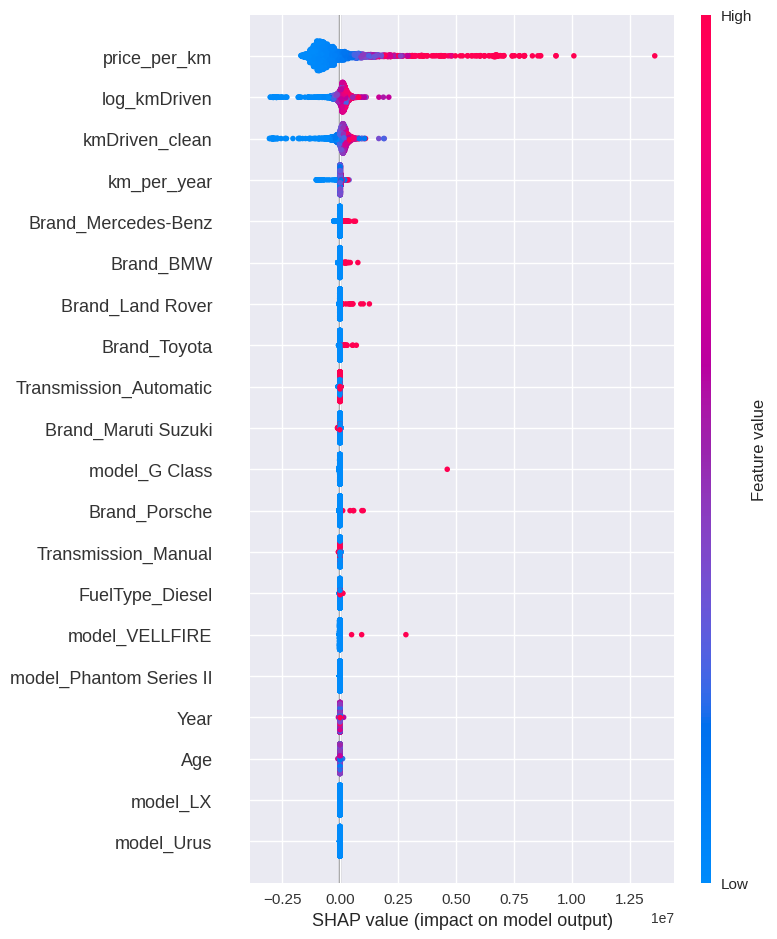

In [10]:
# SHAP Değerleri

explainer = shap.TreeExplainer(model)

X_val_transformed = final_model.named_steps["preprocess"].transform(X_val)

# dense gerekiyorsa
try:
    X_val_dense = X_val_transformed.toarray()
except:
    X_val_dense = X_val_transformed

shap_values = explainer.shap_values(X_val_dense)

shap.summary_plot(shap_values, X_val_dense, feature_names=all_cols)


### SHAP Analizi Özet Bulgular

- SHAP grafiği, modelin fiyat tahmini yaparken hangi özellikleri nasıl kullandığını gösterir.

- Eksen üzerindeki pozitif değerler fiyatı artıran, negatif değerler ise düşüren etkiyi temsil eder.

    - 1. price_per_km → Modelin En Güçlü Belirleyici Özelliği
- Bu özellik fiyatı tek başına çok güçlü şekilde açıklamaktadır.
- Düşük değerli (mavi noktalar) → daha yüksek fiyat etkisi
- Yüksek değerli (kırmızı noktalar) → daha düşük fiyat etkisi
- Bu, aracın kilometre başına fiyatının değer algısını doğrudan yansıttığını gösterir.
    
    - 2. kmDriven_clean & log_kmDriven → Kullanım Yoğunluğu Fiyatı Belirliyor
- Kilometre arttıkça fiyat tahmini net şekilde düşmektedir.
- Hem ham kilometre hem de log dönüşümü güçlü negatif etki yaratmaktadır.
- Bu, modelin kullanılmış araç değer kaybı dinamiğini doğru öğrendiğini gösterir.
    
    - 3. Premium Modeller (VELLFIRE, G Class, Phantom Series II) Pozitif Fiyat Etkisine Sahip
- Bu modeller fiyat tahminini ciddi şekilde yukarı taşımaktadır.
- Kırmızı noktaların sağ tarafta toplanması premium segment etkisini doğrular.

    - 4. Markaların Etkisi: Mercedes, BMW, Land Rover, Porsche → Yukarı Yönlü Etki
-Premium markalar pozitif SHAP etkisi gösteriyor.
-Toyota, Maruti Suzuki gibi hacimli markalar ise fiyatı normalize eden (orta düzey) etki yaratıyor.

    - 5. km_per_year → Yıllık Kullanım Yoğunluğunun Orta Düzey Etkisi Var
- Aracın yılda ne kadar kullanıldığı fiyatı etkiliyor fakat kmDriven kadar güçlü değil.

    - 6. FuelType_Diesel → Hafif Pozitif Etki
- Dizel araçların değer algısı daha yüksek.

    
    - Genel Sonuç
    - Model:

- Kullanım yoğunluğu (km)
- Aracın segment/değer seviyesi (marka & model)
- Fiyat yoğunluğu (price_per_km)
gibi ekonomik olarak mantıklı sinyalleri doğru şekilde yakalamaktadır.

- Bu açıklanabilirlik sonuçları, modelin tutarlı, güvenilir ve gerçek hayata uygun bir yaklaşım kullandığını doğrulamaktadır.